In [4]:
import numpy as np
data = np.load('/content/rho10000.npy', allow_pickle=True)
data = data[:,1:]

In [5]:
labels = data[:, 0].astype(int)
features = data[:, 1:].astype(np.float32)

In [6]:
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements)
    cat_values = np.unique(categories)
    grand_mean = np.mean(measurements)

    ss_between = sum([
        len(measurements[categories == cat]) *
        (np.mean(measurements[categories == cat]) - grand_mean) ** 2
        for cat in cat_values
    ])

    ss_total = np.sum((measurements - grand_mean) ** 2)
    return ss_between / ss_total if ss_total != 0 else 0

for i, name in enumerate(['XxX', 'YxY', 'ZxZ']):
    eta_squared = correlation_ratio(labels, features[:, i])
    print(f"{name}: η² = {eta_squared:.3f}")


XxX: η² = 0.029
YxY: η² = 0.023
ZxZ: η² = 0.001


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42)
acc = cross_val_score(clf, features, labels, cv=5, scoring='accuracy')
print("Mean accuracy:", acc.mean())

Mean accuracy: 0.8


In [8]:
clf.fit(features, labels)
importances = clf.feature_importances_
for name, score in zip(['XxX', 'YxY', 'ZxZ'], importances):
    print(f'{name}: {score:.3f}')


XxX: 0.345
YxY: 0.351
ZxZ: 0.304


In [38]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(features, labels)
print(dict(zip(['XxX', 'YxY', 'ZxZ'], mi)))


{'XxX': np.float64(0.7327456716263039), 'YxY': np.float64(0.7848375666975835), 'ZxZ': np.float64(0.6745042324401196)}


In [9]:
!pip install qiskit qiskit-machine-learning torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [10]:
# Normalize each feature to [0, 1]
min_vals = features.min(axis=0)
max_vals = features.max(axis=0)
features_scaled = (features - min_vals) / (max_vals - min_vals + 1e-8)

# Rescale to [-π, π]
features_scaled = features_scaled * (2 * np.pi) - np.pi

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
import torch

In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, stratify=labels, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [14]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import Estimator

In [33]:
import torch.nn as nn

In [32]:
from qiskit.quantum_info import Pauli

In [30]:
observables = [
    Pauli("ZII"), Pauli("IZI"), Pauli("IIZ"),  # Individual
]

def create_qnn(num_qubits: int = 3):
    x = ParameterVector("x", num_qubits)
    circuit = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        circuit.ry(x[i], i)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2, entanglement="linear")
    circuit.compose(ansatz, inplace=True)

    return EstimatorQNN(
        circuit=circuit,
        input_params=x,
        weight_params=ansatz.parameters,
        estimator=Estimator(),
        input_gradients=True,
        observables=observables
    )

qnn = create_qnn()
model = TorchConnector(qnn)

# Full classifier
classifier = nn.Sequential(
    model,
    nn.Linear(3, 16, bias=True),
    nn.ReLU(),
    nn.Linear(16, 4, bias=True),
)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.LBFGS(classifier.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

for epoch in range(10):
    classifier.train()
    def closure():
        optimizer.zero_grad()
        inputs = X_train_tensor.float()
        if inputs.ndim == 1:
            inputs = inputs.unsqueeze(0)  # Ensure batch shape
        output = classifier(inputs)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        return loss


    loss = optimizer.step(closure)
    scheduler.step()

    classifier.eval()
    with torch.no_grad():
        test_output = classifier(X_test_tensor)
        test_loss = criterion(test_output, y_test_tensor)
        preds = torch.argmax(test_output, dim=1)
        acc = (preds == y_test_tensor).float().mean().item()

    print(f"Epoch {epoch+1:02d}: Train Loss = {loss.item():.4f}, Test Acc = {acc:.4f}")

/tmp/ipython-input-30-2799938768.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator(),
/tmp/ipython-input-30-2799938768.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  return EstimatorQNN(


Epoch 01: Train Loss = 1.4567, Test Acc = 0.9500
Epoch 02: Train Loss = 0.1910, Test Acc = 0.8000
Epoch 03: Train Loss = 0.0372, Test Acc = 0.8500
Epoch 04: Train Loss = 0.0003, Test Acc = 0.8500
Epoch 05: Train Loss = 0.0000, Test Acc = 0.8500
Epoch 06: Train Loss = 0.0000, Test Acc = 0.8500
Epoch 07: Train Loss = 0.0000, Test Acc = 0.8500
Epoch 08: Train Loss = 0.0000, Test Acc = 0.8500
Epoch 09: Train Loss = 0.0000, Test Acc = 0.8500
Epoch 10: Train Loss = 0.0000, Test Acc = 0.8500


In [31]:
torch.save(classifier.state_dict(), '/content/classifier_best_weights.pth')

In [34]:
# Load the new dataset
new_data = np.load('/content/rho10000_2.npy', allow_pickle=True)
new_data = new_data[:, 1:]

# Prepare the new data (same steps as the training data)
new_labels = new_data[:, 0].astype(int)
new_features = new_data[:, 1:].astype(np.float32)

# Normalize and rescale the new features using the same min/max from the original training data
# Assuming min_vals and max_vals are available from previous code execution.
new_features_scaled = (new_features - min_vals) / (max_vals - min_vals + 1e-8)
new_features_scaled = new_features_scaled * (2 * np.pi) - np.pi

# Convert to torch tensors
X_new_tensor = torch.tensor(new_features_scaled, dtype=torch.float32)
y_new_tensor = torch.tensor(new_labels, dtype=torch.long)

In [35]:
# Load the trained classifier's state dictionary
# Make sure the classifier model architecture is defined before loading the state_dict
# Assuming the classifier model 'classifier' is already defined in a previous cell
try:
    classifier.load_state_dict(torch.load('/content/classifier_best_weights.pth'))
    print("Successfully loaded the trained classifier weights.")
except FileNotFoundError:
    print("Error: 'classifier_best_weights.pth' not found. Please make sure the training cell was run successfully to save the weights.")
    # You might want to exit or handle this error appropriately
except RuntimeError as e:
    print(f"Error loading state dictionary: {e}")
    print("This might happen if the model architecture has changed since saving the weights.")

# Set the model to evaluation mode
classifier.eval()

Successfully loaded the trained classifier weights.


Sequential(
  (0): TorchConnector()
  (1): Linear(in_features=3, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=4, bias=True)
)

In [36]:
# Evaluate the classifier on the new data
with torch.no_grad():
    new_output = classifier(X_new_tensor)
    new_preds = torch.argmax(new_output, dim=1)
    new_acc = (new_preds == y_new_tensor).float().mean().item()

print(f"Accuracy on the new dataset: {new_acc:.4f}")

Accuracy on the new dataset: 0.8441


In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns

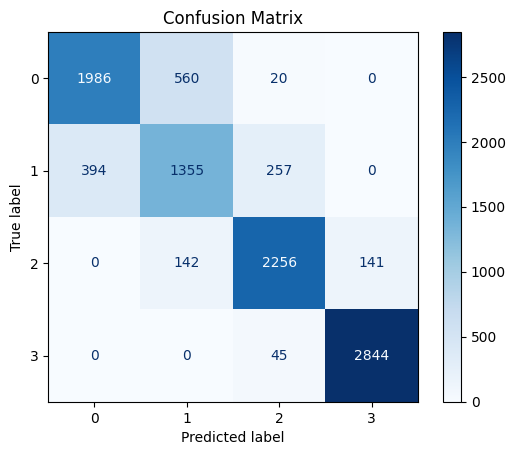

In [55]:
cm = confusion_matrix(y_new_tensor, new_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("/content/confusion matrix.png", dpi=300)
plt.show()

In [39]:
with torch.no_grad():
    embeddings = classifier(X_new_tensor).numpy()

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
reduced = tsne.fit_transform(embeddings)

ValueError: All arrays must be of the same length

<Figure size 600x600 with 0 Axes>

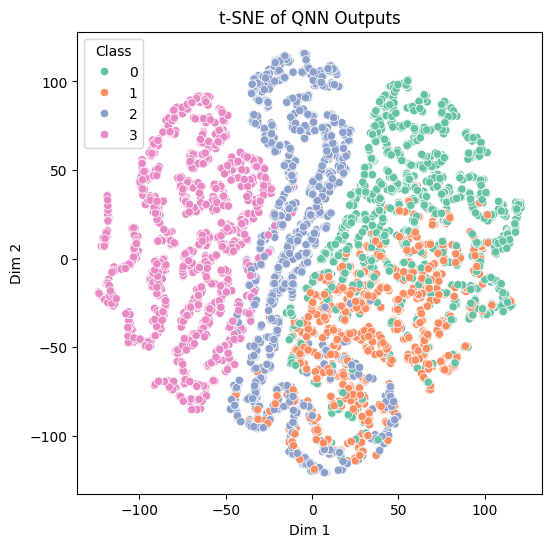

In [54]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=y_new_tensor.numpy(), palette="Set2")
plt.title("t-SNE of QNN Outputs")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Class")
plt.savefig("/content/tsne.png", dpi=300)
plt.show()

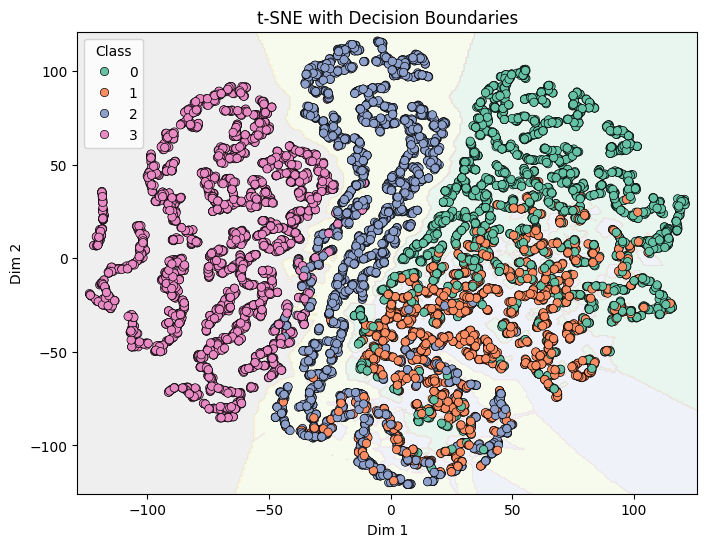

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(reduced, y_new_tensor.numpy())

# 4. Create mesh grid for decision regions
x_min, x_max = reduced[:, 0].min() - 5, reduced[:, 0].max() + 5
y_min, y_max = reduced[:, 1].min() - 5, reduced[:, 1].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid).reshape(xx.shape)

# 5. Plot decision boundaries and points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=y_new_tensor.numpy(), palette="Set2", edgecolor='k')
plt.title("t-SNE with Decision Boundaries")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Class")
plt.show()

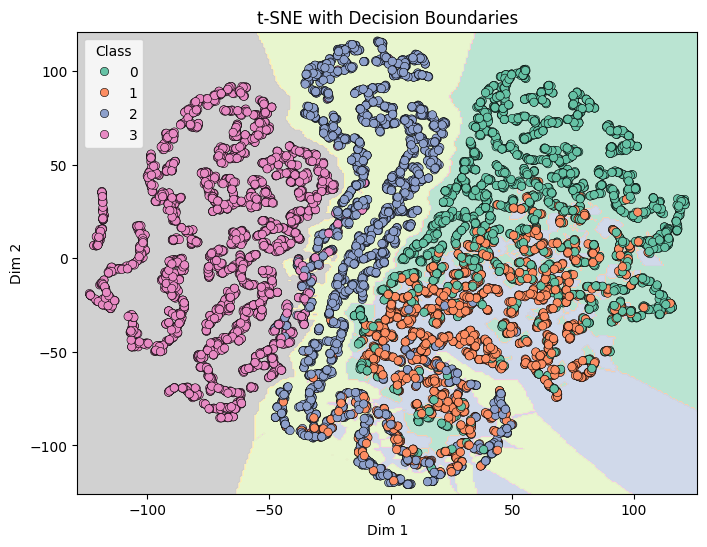

In [53]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.9, cmap='Pastel2')
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=y_new_tensor.numpy(),
    palette="Set2",
    edgecolor='black',
    linewidth=0.4,
    alpha = 1
)
plt.title("t-SNE with Decision Boundaries")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Class")
plt.savefig("/content/tsne_with_decision_boundaries.png", dpi=300)
plt.show()

In [56]:
!pip install torchviz graphviz

In [57]:
from torchviz import make_dot

# Forward pass with dummy input to build the graph
dummy_input = X_train_tensor[:1].float()
output = classifier(dummy_input)

# Create the graph
dot = make_dot(output, params=dict(classifier.named_parameters()))
dot.format = 'png'
dot.render('/content/classifier_architecture')  # Saves as classifier_architecture.png

'/content/classifier_architecture.png'

In [73]:
!pip install pdflatex

  Attempting uninstall: attrs
    Found existing installation: attrs 25.3.0
    Uninstalling attrs-25.3.0:
      Successfully uninstalled attrs-25.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
referencing 0.36.2 requires attrs>=22.2.0, but you have attrs 18.2.0 which is incompatible.
jsonschema 4.24.0 requires attrs>=22.2.0, but you have attrs 18.2.0 which is incompatible.


In [76]:
with open("/content/qnn_circuit.txt", "w") as f:
    f.write(qnn.circuit.draw(output='text').single_string())

In [77]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 14.9 MB/s eta 0:00:00


In [80]:
import qutip as qt

In [81]:
def channel(initial_state, phase_damp_param =0 , amp_damp_param = 0 , c_phase_damp = 0 , c_amp_damp = 0 ,time = 1):
    rho0 = qt.Qobj(initial_state)
    rho0.dims = [[2,2],[2,2]]
    #takes damping paramater and time as input , gives final state as output

    gamma_amp = phase_damp_param  # amplitude damping rate
    gamma_phase = amp_damp_param  # phase damping rate

    gamma_amp_c = c_amp_damp
    gamma_phase_c = c_phase_damp

    # --- COLLAPSE OPERATORS ---


    c1_amp = np.sqrt(gamma_amp) * qt.tensor(qt.destroy(2), qt.qeye(2))
    c2_amp = np.sqrt(gamma_amp) * qt.tensor(qt.qeye(2), qt.destroy(2))


    proj1 = qt.basis(2,1) * qt.basis(2,1).dag()
    c1_phase = np.sqrt(gamma_phase) * qt.tensor(qt.sigmaz(), qt.qeye(2))
    c2_phase = np.sqrt(gamma_phase) * qt.tensor(qt.qeye(2), qt.sigmaz())

    # Correlated noises
    c1_correlated_amp = np.sqrt(gamma_amp_c) * qt.tensor(qt.destroy(2), qt.destroy(2))
    c1_correlated_phase = np.sqrt(gamma_phase_c) * qt.tensor(qt.sigmaz(), qt.sigmaz())

    c_ops_all = [c1_amp, c2_amp, c1_phase, c2_phase ,c1_correlated_amp , c1_correlated_phase ]
    c_ops_phase = [ c1_phase, c2_phase]
    c_ops_amp = [c1_amp, c2_amp]

    # No Hamiltonian (we're only studying damping)
    H = qt.tensor(qt.qeye(2),qt.qeye(2))

    # Time evolution
    tlist = np.linspace(0, time, 200)

    # Solve master equation
    result = qt.mesolve(H, rho0, tlist, c_ops_all)

    return result.final_state

In [79]:
new_data_comm = np.load('/content/rho10000_2.npy', allow_pickle=True)

In [84]:
X = qt.tensor(qt.sigmax() ,qt.sigmax())
Y = qt.tensor(qt.sigmay() ,qt.sigmay())
Z = qt.tensor(qt.sigmaz() ,qt.sigmaz())
I = qt.tensor(qt.qeye(2) ,qt.qeye(2))
def exp_val_finder(rho):
    return [np.real((rho*X).tr()) , np.real((rho*Y).tr()) , np.real((rho*Z).tr())]

In [85]:
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix)
    input = exp_val_finder(rho_bob)


[-0.11291090316811189, 0.186184111369365, -0.08042633844484873]


In [88]:
predicted_labels_from_exp = []
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix)
    exp_values = exp_val_finder(rho_bob)

    # Prepare the input for the classifier
    exp_values_np = np.array(exp_values, dtype=np.float32)

    # Normalize the input features using the same min/max from the original training data
    # Assuming min_vals and max_vals are available from previous code execution.
    exp_values_scaled = (exp_values_np - min_vals) / (max_vals - min_vals + 1e-8)

    # Rescale to [-π, π]
    exp_values_scaled = exp_values_scaled * (2 * np.pi) - np.pi

    # Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(exp_values_scaled, dtype=torch.float32).unsqueeze(0)

    # Make prediction using the classifier
    classifier.eval() # Set the model to evaluation mode
    with torch.no_grad():
        output = classifier(input_tensor)
        _, predicted_label = torch.max(output, 1)

    predicted_labels_from_exp.append(predicted_label.item())

# You can now analyze predicted_labels_from_exp
print("Predicted labels from experimental values:", predicted_labels_from_exp)

Predicted labels from experimental values: [0, 3, 2, 1, 2, 3, 0, 2, 3, 2, 0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 0, 3, 2, 0, 0, 2, 0, 3, 0, 1, 2, 2, 2, 3, 1, 1, 2, 3, 2, 3, 0, 2, 3, 1, 2, 0, 3, 3, 2, 2, 3, 3, 1, 3, 2, 1, 2, 3, 1, 0, 1, 3, 1, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 1, 0, 3, 2, 2, 3, 2, 2, 3, 3, 2, 0, 2, 2, 2, 3, 2, 1, 0, 0, 2, 3, 2, 0, 0, 1, 3, 2, 3, 3, 1, 0, 0, 2, 3, 2, 3, 2, 3, 3, 2, 1, 2, 0, 0, 2, 2, 3, 3, 3, 3, 3, 2, 3, 0, 2, 0, 2, 3, 1, 3, 2, 2, 1, 3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 2, 1, 0, 3, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 2, 3, 2, 2, 0, 0, 3, 3, 2, 2, 3, 0, 2, 1, 0, 3, 1, 1, 3, 2, 2, 3, 0, 0, 1, 3, 1, 3, 2, 0, 2, 0, 3, 1, 3, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 0, 3, 1, 0, 1, 3, 0, 1, 0, 3, 3, 3, 2, 1, 0, 0, 1, 0, 1, 2, 0, 3, 2, 3, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 3, 2, 2, 3, 0, 1, 2, 0, 2, 0, 3, 0, 0, 1, 0, 3, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 1, 3, 2, 3, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 3, 2, 3, 0, 0, 3, 3, 2, 2, 0, 3, 0, 0, 1, 0, 2, 3, 1, 2, 0, 3, 1, 1, 1, 1, 1, 2, 3, 2, 3, 2, 2, 1, 3, 2,

In [89]:
from sklearn.metrics import accuracy_score

# Extract the true labels from the new dataset
# The true label is the second value (index 1) of the original row before slicing
true_labels_new_dataset = new_data_comm[:, 1].astype(int)

# Calculate the accuracy by comparing predicted_labels_from_exp with the true labels
accuracy_exp = accuracy_score(true_labels_new_dataset, predicted_labels_from_exp)

print(f"\nAccuracy using predicted labels from experimental values: {accuracy_exp:.4f}")


Accuracy using predicted labels from experimental values: 0.8441


In [91]:
predicted_labels_from_exp = []
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix, phase_damp_param =0.5 , amp_damp_param = 0 , c_phase_damp = 0 , c_amp_damp = 0)
    exp_values = exp_val_finder(rho_bob)

    # Prepare the input for the classifier
    exp_values_np = np.array(exp_values, dtype=np.float32)

    # Normalize the input features using the same min/max from the original training data
    # Assuming min_vals and max_vals are available from previous code execution.
    exp_values_scaled = (exp_values_np - min_vals) / (max_vals - min_vals + 1e-8)

    # Rescale to [-π, π]
    exp_values_scaled = exp_values_scaled * (2 * np.pi) - np.pi

    # Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(exp_values_scaled, dtype=torch.float32).unsqueeze(0)

    # Make prediction using the classifier
    classifier.eval() # Set the model to evaluation mode
    with torch.no_grad():
        output = classifier(input_tensor)
        _, predicted_label = torch.max(output, 1)

    predicted_labels_from_exp.append(predicted_label.item())

# You can now analyze predicted_labels_from_exp
print("Predicted labels from experimental values:", predicted_labels_from_exp)

accuracy_exp = accuracy_score(true_labels_new_dataset, predicted_labels_from_exp)

print(f"\nAccuracy using predicted labels from experimental values: {accuracy_exp:.4f}")

Predicted labels from experimental values: [0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 0,

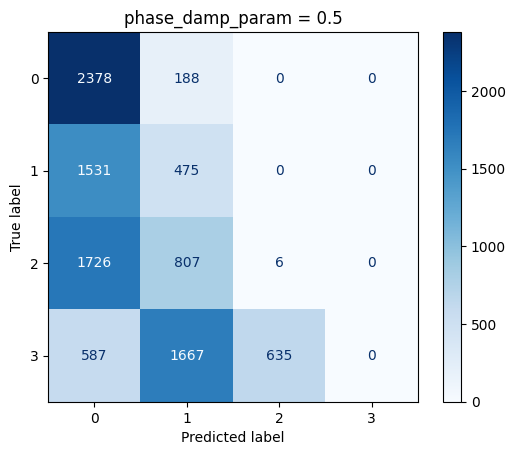

In [97]:
cm_exp = confusion_matrix(true_labels_new_dataset, predicted_labels_from_exp)

# Display the confusion matrix
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp)
disp_exp.plot(cmap="Blues")
plt.title("phase_damp_param = 0.5")
plt.savefig("/content/confusion_matrix_experimental.png", dpi=300)
plt.show()

In [92]:
predicted_labels_from_exp_1 = []
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix, phase_damp_param =0 , amp_damp_param = 0.5 , c_phase_damp = 0 , c_amp_damp = 0)
    exp_values = exp_val_finder(rho_bob)

    # Prepare the input for the classifier
    exp_values_np = np.array(exp_values, dtype=np.float32)

    # Normalize the input features using the same min/max from the original training data
    # Assuming min_vals and max_vals are available from previous code execution.
    exp_values_scaled = (exp_values_np - min_vals) / (max_vals - min_vals + 1e-8)

    # Rescale to [-π, π]
    exp_values_scaled = exp_values_scaled * (2 * np.pi) - np.pi

    # Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(exp_values_scaled, dtype=torch.float32).unsqueeze(0)

    # Make prediction using the classifier
    classifier.eval() # Set the model to evaluation mode
    with torch.no_grad():
        output = classifier(input_tensor)
        _, predicted_label = torch.max(output, 1)

    predicted_labels_from_exp_1.append(predicted_label.item())

# You can now analyze predicted_labels_from_exp
print("Predicted labels from experimental values:", predicted_labels_from_exp_1)

accuracy_exp = accuracy_score(true_labels_new_dataset, predicted_labels_from_exp_1)

print(f"\nAccuracy using predicted labels from experimental values: {accuracy_exp:.4f}")

Predicted labels from experimental values: [0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 1, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1,

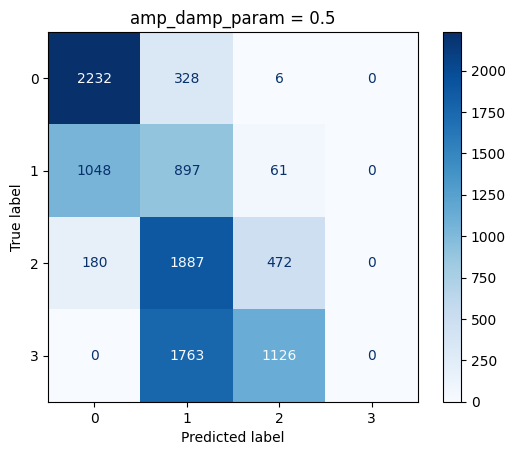

In [98]:
cm_exp = confusion_matrix(true_labels_new_dataset, predicted_labels_from_exp_1)

# Display the confusion matrix
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp)
disp_exp.plot(cmap="Blues")
plt.title("amp_damp_param = 0.5")
plt.savefig("/content/confusion_matrix_experimental_1.png", dpi=300)
plt.show()

In [93]:
predicted_labels_from_exp_2 = []
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix, phase_damp_param =0 , amp_damp_param = 0 , c_phase_damp = 0.5 , c_amp_damp = 0)
    exp_values = exp_val_finder(rho_bob)

    # Prepare the input for the classifier
    exp_values_np = np.array(exp_values, dtype=np.float32)

    # Normalize the input features using the same min/max from the original training data
    # Assuming min_vals and max_vals are available from previous code execution.
    exp_values_scaled = (exp_values_np - min_vals) / (max_vals - min_vals + 1e-8)

    # Rescale to [-π, π]
    exp_values_scaled = exp_values_scaled * (2 * np.pi) - np.pi

    # Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(exp_values_scaled, dtype=torch.float32).unsqueeze(0)

    # Make prediction using the classifier
    classifier.eval() # Set the model to evaluation mode
    with torch.no_grad():
        output = classifier(input_tensor)
        _, predicted_label = torch.max(output, 1)

    predicted_labels_from_exp_2.append(predicted_label.item())

# You can now analyze predicted_labels_from_exp
print("Predicted labels from experimental values:", predicted_labels_from_exp_2)

accuracy_exp = accuracy_score(true_labels_new_dataset, predicted_labels_from_exp_2)

print(f"\nAccuracy using predicted labels from experimental values: {accuracy_exp:.4f}")

Predicted labels from experimental values: [0, 3, 2, 1, 2, 3, 0, 2, 3, 2, 0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 0, 3, 2, 0, 0, 2, 0, 3, 0, 1, 2, 2, 2, 3, 1, 1, 2, 3, 2, 3, 0, 2, 3, 1, 2, 0, 3, 3, 2, 2, 3, 3, 1, 3, 2, 1, 2, 3, 1, 0, 1, 3, 1, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 1, 0, 3, 2, 2, 3, 2, 2, 3, 3, 2, 0, 2, 2, 2, 3, 2, 1, 0, 0, 2, 3, 2, 0, 0, 1, 3, 2, 3, 3, 1, 0, 0, 2, 3, 2, 3, 2, 3, 3, 2, 1, 2, 0, 0, 2, 2, 3, 3, 3, 3, 3, 2, 3, 0, 2, 0, 2, 3, 1, 3, 2, 2, 1, 3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 2, 1, 0, 3, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 2, 3, 2, 2, 0, 0, 3, 3, 2, 2, 3, 0, 2, 1, 0, 3, 1, 1, 3, 2, 2, 3, 0, 0, 1, 3, 1, 3, 2, 0, 2, 0, 3, 1, 3, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 0, 3, 1, 0, 1, 3, 0, 1, 0, 3, 3, 3, 2, 1, 0, 0, 1, 0, 1, 2, 0, 3, 2, 3, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 3, 2, 2, 3, 0, 1, 2, 0, 2, 0, 3, 0, 0, 1, 0, 3, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 1, 3, 2, 3, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 3, 2, 3, 0, 0, 3, 3, 2, 2, 0, 3, 0, 0, 1, 0, 2, 3, 1, 2, 0, 3, 1, 1, 1, 1, 1, 2, 3, 2, 3, 2, 2, 1, 3, 2,

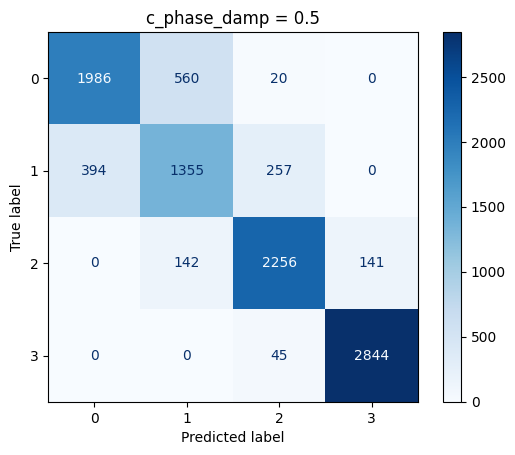

In [99]:
cm_exp = confusion_matrix(true_labels_new_dataset, predicted_labels_from_exp_2)

# Display the confusion matrix
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp)
disp_exp.plot(cmap="Blues")
plt.title("c_phase_damp = 0.5")
plt.savefig("/content/confusion_matrix_experimental_2.png", dpi=300)
plt.show()

In [94]:
predicted_labels_from_exp_3 = []
for row in new_data_comm:
    initial_state_matrix = row[0]
    rho_bob = channel(initial_state_matrix, phase_damp_param =0 , amp_damp_param = 0 , c_phase_damp = 0 , c_amp_damp = 0.5)
    exp_values = exp_val_finder(rho_bob)

    # Prepare the input for the classifier
    exp_values_np = np.array(exp_values, dtype=np.float32)

    # Normalize the input features using the same min/max from the original training data
    # Assuming min_vals and max_vals are available from previous code execution.
    exp_values_scaled = (exp_values_np - min_vals) / (max_vals - min_vals + 1e-8)

    # Rescale to [-π, π]
    exp_values_scaled = exp_values_scaled * (2 * np.pi) - np.pi

    # Convert to torch tensor and add batch dimension
    input_tensor = torch.tensor(exp_values_scaled, dtype=torch.float32).unsqueeze(0)

    # Make prediction using the classifier
    classifier.eval() # Set the model to evaluation mode
    with torch.no_grad():
        output = classifier(input_tensor)
        _, predicted_label = torch.max(output, 1)

    predicted_labels_from_exp_3.append(predicted_label.item())

# You can now analyze predicted_labels_from_exp
print("Predicted labels from experimental values:", predicted_labels_from_exp_3)

accuracy_exp = accuracy_score(true_labels_new_dataset, predicted_labels_from_exp_3)

print(f"\nAccuracy using predicted labels from experimental values: {accuracy_exp:.4f}")

Predicted labels from experimental values: [0, 3, 2, 0, 2, 3, 0, 2, 2, 1, 0, 3, 2, 3, 2, 2, 3, 3, 3, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 2, 3, 0, 1, 2, 3, 2, 2, 0, 2, 2, 1, 2, 0, 2, 3, 2, 2, 2, 3, 1, 2, 2, 1, 2, 3, 1, 0, 1, 3, 1, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 1, 2, 3, 1, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 3, 3, 1, 0, 0, 2, 3, 2, 3, 2, 2, 3, 2, 1, 2, 0, 0, 2, 2, 3, 2, 2, 3, 2, 2, 3, 0, 2, 0, 2, 3, 1, 3, 2, 1, 1, 2, 2, 1, 2, 2, 3, 2, 2, 1, 1, 3, 2, 1, 0, 3, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 2, 3, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 1, 0, 3, 1, 1, 3, 2, 2, 3, 0, 0, 1, 2, 1, 3, 2, 0, 2, 0, 3, 1, 3, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 0, 3, 1, 0, 1, 2, 0, 1, 0, 2, 3, 2, 3, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 3, 0, 0, 1, 0, 1, 0, 1, 2, 1, 2, 3, 2, 2, 3, 0, 1, 2, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 3, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 0, 1, 3, 2, 3, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 3, 1,

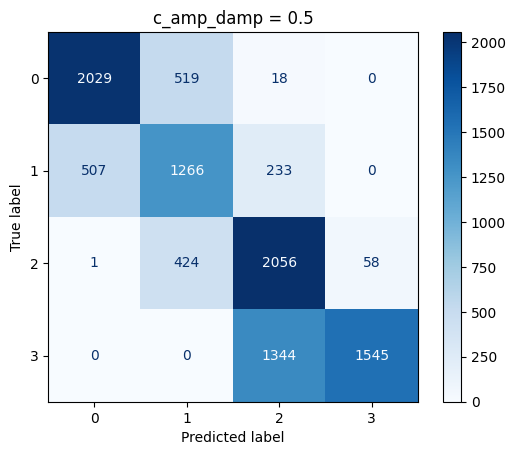

In [100]:
cm_exp = confusion_matrix(true_labels_new_dataset, predicted_labels_from_exp_3)

# Display the confusion matrix
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp)
disp_exp.plot(cmap="Blues")
plt.title("c_amp_damp = 0.5")
plt.savefig("/content/confusion_matrix_experimental_3.png", dpi=300)
plt.show()